<a href="https://colab.research.google.com/github/lightwsrld/pytorch/blob/master/CH5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
train_dataset  = torchvision.datasets.FashionMNIST("FashionMNIST/", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_dataset  = torchvision.datasets.FashionMNIST("FashionMNIST/", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))

100%|██████████| 26421880/26421880 [00:01<00:00, 16434640.94it/s]


Extracting FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to FashionMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 294337.65it/s]


Extracting FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to FashionMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5587742.67it/s]


Extracting FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to FashionMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 11388331.75it/s]


Extracting FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to FashionMNIST/FashionMNIST/raw



In [ ]:
# 원하는 크기의 배치 단위로 데이터 불러오기
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=100)

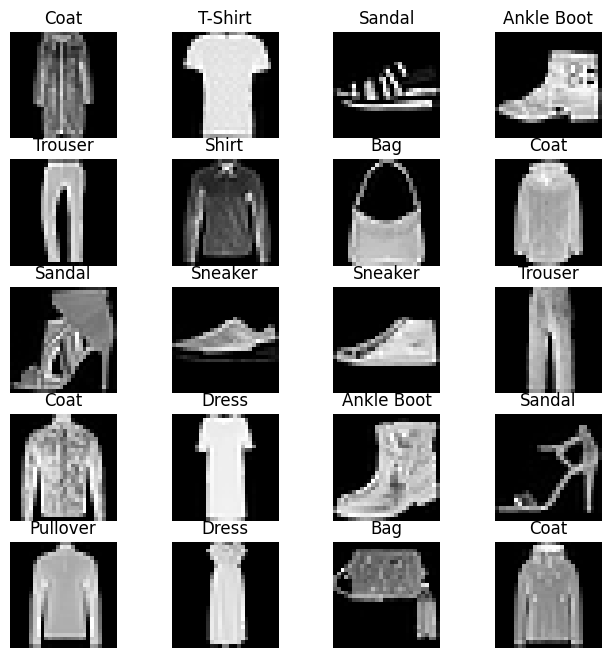

In [ ]:
# 10개의 레이블로 구성
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
## 참고 - 평균이 0이고 표준편차가 1인 가우시안 정규분포 난수를 행렬로 출력
np.random.randn(4,2)

array([[-1.13716627, -0.27966192],
       [-1.49026254, -0.3784322 ],
       [-1.73194743,  0.8064245 ],
       [ 0.39597842, -0.44192791]])

In [ ]:
# 심층 신경망 모델 생성

class FashionDNN(nn.Module):
  def __init__(self):
    super(FashionDNN, self).__init__()
    self.fc1 = nn.Linear(in_features=784, out_features=256)
    self.drop = nn.Dropout(0.25)
    self.fc2 = nn.Linear(in_features=256, out_features=128)
    self.fc3 = nn.Linear(in_features=128, out_features=10)

  def forward(self, input_data):      # 실제로 데이터 연산이 진행되는 부분
    out = input_data.view(-1, 784)
    out = F.relu(self.fc1(out))
    out = self.drop(out)
    out = F.relu(self.fc2(out))
    out = self.fc3(out)
    return out

In [ ]:
## 활성화 함수 지정
# 1. F.relu() : forward 함수에서 정의
# 2. nn.ReLU() : __init__() 함수에서 정의

In [ ]:
learning_rate = 0.001
model = FashionDNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
  for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)

      train = Variable(images.view(100, 1, 28, 28))
      labels = Variable(labels)            # Autograd는 Variable을 사용해서 역전파를 위한 미분 값을 자동으로 계산

      outputs = model(train)
      loss = criterion(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      count += 1

      if not (count % 50):
        total = 0
        correct = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            labels_list.append(labels)
            test = Variable(images.view(100, 1, 28, 28))
            outputs = model(test)
            predictions = torch.max(outputs, 1)[1].to(device)      # 각 input image에 대해 신뢰 점수 (최대 로짓)가 가장 높은 클래스의 인덱스를 선택
            predictions_list.append(predictions)
            correct += (predictions == labels).sum()
            total += len(labels)

        accuracy = correct * 100 / total
        loss_list.append(loss.data)
        iteration_list.append(count)
        accuracy_list.append(accuracy)

      if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.5951564908027649, Accuracy: 83.52999877929688%
Iteration: 1000, Loss: 0.4769541025161743, Accuracy: 84.06999969482422%
Iteration: 1500, Loss: 0.3458402156829834, Accuracy: 84.94000244140625%
Iteration: 2000, Loss: 0.3454805612564087, Accuracy: 86.01000213623047%
Iteration: 2500, Loss: 0.24561795592308044, Accuracy: 86.2300033569336%
Iteration: 3000, Loss: 0.30961430072784424, Accuracy: 86.61000061035156%


In [ ]:
# 합성곱 신경망 모델 생성

class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)   # 마지막 계층의 out_features는 class 개수를 의미

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)    # fc layer로 전달해야 하기 때문에 데이터의 형태를 1차원으로 변경
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [ ]:
learning_rate = 0.001;
model = FashionCNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [ ]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.4449010491371155, Accuracy: 87.77999877929688%
Iteration: 1000, Loss: 0.3016427755355835, Accuracy: 86.73999786376953%
Iteration: 1500, Loss: 0.29567375779151917, Accuracy: 88.87999725341797%
Iteration: 2000, Loss: 0.18376807868480682, Accuracy: 89.7300033569336%
Iteration: 2500, Loss: 0.17779725790023804, Accuracy: 89.73999786376953%
Iteration: 3000, Loss: 0.17527176439762115, Accuracy: 89.2699966430664%
